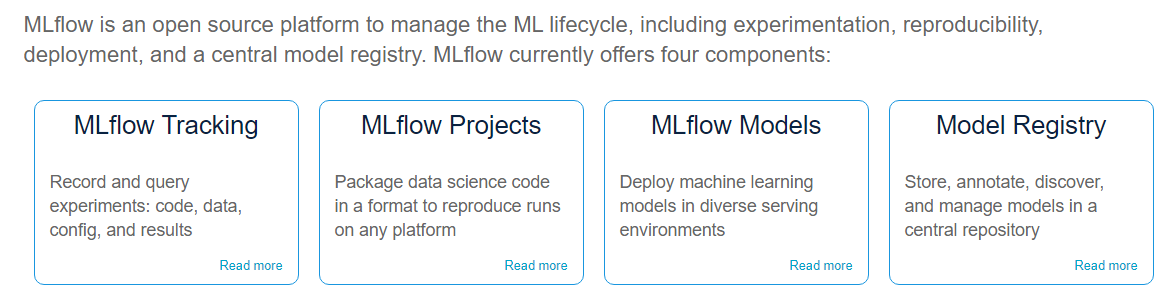

**We are focusing on MLflow Tracking Today**

In [ ]:
!pip install mlflow
!pip install sklearn
!pip install pyngrok

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
import mlflow
import mlflow.sklearn
#import sys
#import os

import mlflow
import mlflow.sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.0 MB 175 kB/s 
     |████████████████████████████████| 79 kB 7.3 MB/s 
     |████████████████████████████████| 146 kB 57.5 MB/s 
     |████████████████████████████████| 181 kB 52.3 MB/s 
     |████████████████████████████████| 81 kB 9.6 MB/s 
     |████████████████████████████████| 209 kB 55.7 MB/s 
     |████████████████████████████████| 78 kB 4.7 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 63 kB 1.0 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.17.2-py3-none-any.whl size=143915 sha256=751c6c43a297bdf922bf777c8a84f46e15ad20487a6f2be88d2737b84af54e52
  Stored in directory: /root/.cache/pip/wheels/e4/94/af/ed16e5ddf301a3628d1d3e15ef95bbb79e076a3be48c11699b
Successfully built databricks-cli
Looking in indexes: http

In [11]:
!mlflow

Usage: mlflow [OPTIONS] COMMAND [ARGS]...

Options:
  --version  Show the version and exit.
  --help     Show this message and exit.

Commands:
  artifacts    Upload, list, and download...
  azureml      Serve models on Azure ML.
  db           Commands for managing an MLflow...
  deployments  Deploy MLflow models to custom...
  experiments  Manage experiments.
  gc           Permanently delete runs in the
               `deleted` lifecycle stage.

  models       Deploy MLflow models locally.
  pipelines    Run MLflow Pipelines and inspect...
  run          Run an MLflow project from the...
  runs         Manage runs.
  sagemaker    Serve models on SageMaker.
  server       Run the MLflow tracking server.
  ui           Launch the MLflow tracking UI
               for...


In [12]:
from pyngrok import ngrok


In [13]:
#name the experiement
mlflow.set_experiment('MLflow Model Tracking')

<Experiment: artifact_location='file:///content/mlruns/1', experiment_id='1', lifecycle_stage='active', name='MLflow Model Tracking', tags={}>

In [14]:
ngrok.kill()

In [15]:
get_ipython().system_raw("mlflow ui --port 5000 &")
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)

In [16]:
!ngrok authtoken 'Your AutoToken'

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [17]:
print("MLflow UI ", ngrok_tunnel.public_url)

MLflow UI  https://5a1c-34-85-128-206.ngrok.io


We are going to use elastic net regression as an example to show the tracking capabilities of MLflow. The modelling itself is not the focus of this class but if you are not familiar with elastic net regression and want to know more, here is the [link](https://machinelearningmastery.com/elastic-net-regression-in-python/). [This](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) is the official elasticnet package documentation. 


In [18]:
from google.colab import files
uploaded = files.upload()

Saving Housing.csv to Housing.csv


In [19]:
data = pd.read_csv("Housing.csv")

In [20]:
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [21]:
def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2

In [22]:

def train_model(alpha,l1_ratio):
    train, test = train_test_split(data)


    train_x = train.drop(['price','mainroad',
                          'guestroom',
                          'basement',
                          'hotwaterheating',
                          'airconditioning',
                          'prefarea',
                          'furnishingstatus'], axis=1)
    test_x = test.drop(['price','mainroad',
                        'guestroom',
                        'basement',
                        'hotwaterheating',
                        'airconditioning',
                        'prefarea',
                        'furnishingstatus'], axis=1)
    train_y = train[["price"]]
    test_y = test[["price"]]

    with mlflow.start_run():
        lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        lr.fit(train_x, train_y)

        predicted_qualities = lr.predict(test_x)

        (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)
        print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        mlflow.log_param("alpha", alpha)
        mlflow.log_param("l1_ratio", l1_ratio)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        mlflow.sklearn.log_model(lr, "model")

Note: we can log all metrics and models, but if we want to leverage the model registering component of MLflow we need to set up a database. Due to the time constraint, we will skip this database setting for now. You can read [This Post](https://towardsdatascience.com/version-your-machine-learning-models-with-mlflow-9d6bbf8eb273) and [This Post](https://www.mlflow.org/docs/latest/model-registry.html#model-registry-workflows) after the class. 

In [23]:
alpha_list = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
l1_ratio_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.9, 0.8, 0.7, 0.6]

for alp, l1 in zip(alpha_list, l1_ratio_list):
    train_model(alp, l1)

Elasticnet model (alpha=0.900000, l1_ratio=0.100000):
  RMSE: 1180599.3847873039
  MAE: 831852.5682023981
  R2: 0.4385768199965675
Elasticnet model (alpha=0.800000, l1_ratio=0.200000):
  RMSE: 1429468.6526582814
  MAE: 1011875.3307406463
  R2: 0.4924242314455206
Elasticnet model (alpha=0.700000, l1_ratio=0.300000):
  RMSE: 1354862.3932823045
  MAE: 988227.9694123529
  R2: 0.40796258282093156
Elasticnet model (alpha=0.600000, l1_ratio=0.400000):
  RMSE: 1239078.426140115
  MAE: 953475.0847325876
  R2: 0.32335242886138416
Elasticnet model (alpha=0.500000, l1_ratio=0.500000):
  RMSE: 1327870.8056897519
  MAE: 931680.361647959
  R2: 0.5416998420883428
Elasticnet model (alpha=0.400000, l1_ratio=0.900000):
  RMSE: 1436298.7643827943
  MAE: 1029180.5040491865
  R2: 0.49505881366836524
Elasticnet model (alpha=0.300000, l1_ratio=0.800000):
  RMSE: 1230801.586819745
  MAE: 878296.8589039139
  R2: 0.6053680626940885
Elasticnet model (alpha=0.200000, l1_ratio=0.700000):
  RMSE: 1145350.6524527185


In [24]:
alpha_list = [0.01]
l1_ratio_list = [0.01]

for alp, l1 in zip(alpha_list, l1_ratio_list):
    train_model(alp, l1)

Elasticnet model (alpha=0.010000, l1_ratio=0.010000):
  RMSE: 1058209.6175794532
  MAE: 786689.1278045798
  R2: 0.5612312755622824


In [25]:
ngrok.kill()